## FP3 - Final
### Jacob Avenaim

***

Within this section, we will be exploring the ever present problem of predicting stock prices. In particular, we will be analyzing and predicting the prices for GME following the massive price surge the prior months due to a huge short squeeze. The label we want to predict will be the price of GME. With this being said, there are many covariates that affect the price of stock. Within this model, we will be focusing on the “Open, High, Low, Adj Close, and Volume,” as well as two complementary stocks, AMC Theaters (AMC) and Nokia (NOK), that were shorted as well during the same time frame. Lastly, our last two explanatory variables will come from larger market data from the S&P 500 as well as NASDAQ. To clarify some definitions, stocks are publicly traded ownership of corporations. To put it simpler, it’s an exchange of money now (price of stock), for a stream of future profits of the corporation. Further, substitutes are typically consumed in place of the other, and a complement is consumed together. In our case, AMC and NOK are both complements, in which they both faced similar but smaller short squeeze than GME. When analyzing the price movement of both companies, there was a massive exponential spike in price these past months, in which all three companies followed a very similar price change trend. This is due to the fact that all three companies were shorted with massive capital to try and drive the stock down. The reason for this is when you short a stock, it’s the right to sell at whatever strike price they enter the contract. If the price goes down, the short sellers get to sell at the higher price leading to profits. In response to this, many smaller investors caugnt on to this, so they entered into call options. Call options are the right to buy at strike price, so if the price goes up, they get to sell at the higher price. To put this all together, these two actions caused a massive squeeze was due to the large amount of capital on the short sell side. Due to this, when the smaller investors started to in large quantities enter call options, the price would go up, so the the large hedge fund companies had to hedge their risk (buy stock) which skyrocketed the stock in order to mitigate their losses. But with AMC and NOK being complements, an increase in the use of complements shifts the demand curve up (increased demand). So, it can be predicted that a short squeeze would lead to higher prices for GME, which would in theory shift AMC and NOK price up as well. An economist and or politician should care about the prediction of prices of stocks as it can indicate macro market trends. For example, the price of a stock typically is an indication of high valuation which can be a precursor to market performance. 

***

## Sources
Yahoo Finance


***

# Prep
- read in csv files
- set index to date because that is present within all data frames
- add features

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm # progress bar

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model as lm
from sklearn.svm import SVR, LinearSVR


from sklearn.metrics import plot_confusion_matrix, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, train_test_split



sns.set(rc = {'axes.titlesize': 24,
                 'axes.labelsize': 20,
                 'xtick.labelsize': 12,
                'ytick.labelsize': 12,
                 'figure.figsize': (12, 4)})

In [2]:
gme = pd.read_pickle('final_data.pkl')

***
## Training

In [3]:
y = gme['Close']
x = gme.drop(columns = 'Close')

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 4/5, random_state = 490)

x_train_std = x_train.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)
x_test_std  = x_test.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)

x_train_std = sm.add_constant(x_train_std)
x_test_std  = sm.add_constant(x_test_std)
x_train     = sm.add_constant(x_train)
x_test      = sm.add_constant(x_test)

***
# Cross-Validation 

In [4]:
param_grid = [
    {'alpha': 10**np.linspace(-3, 3, num = 20)}
]

# We are manually supplying an intercept
# and standardized (not normalized) the features
cv_lasso = lm.Lasso(fit_intercept = False, normalize = False,
                    random_state = 490)
grid_search = GridSearchCV(cv_lasso, param_grid, cv = 5,
                         scoring = 'neg_root_mean_squared_error')
grid_search.fit(x_train_std, y_train)
print(grid_search.best_params_)
best = grid_search.best_params_['alpha']
best

{'alpha': 0.018329807108324356}


0.018329807108324356

***
Once we have identified the best value of $\alpha$, then the next step is to estimate the full model using a regularized model. 

In [5]:
fit_lasso_tuned = sm.OLS(y_train, x_train_std).fit_regularized(L1_wt = 1, alpha = best)
fit_lasso_tuned.params

const              24.585150
Open                8.852958
High                4.545573
Low                 7.432282
Adj Close           3.001447
Volume              0.000000
nok_close           0.000000
bb_close            0.000000
gme_lag_period1    -5.026154
gme_lag_period2     0.953012
gme_lag_period3     0.000000
dtype: float64

In [6]:
rmse_lasso = np.sqrt(np.mean(  (y_test - fit_lasso_tuned.predict(x_test_std))**2  ))
rmse_lasso

1.3761124690475093

***
Estimate the full model using a non-regularized model using $\alpha$

In [7]:
beta = fit_lasso_tuned.params
beta.index[beta == 0]

Index(['Volume', 'nok_close', 'bb_close', 'gme_lag_period3'], dtype='object')

In [8]:
x_train_std_trim = x_train_std.loc[:, ~x_train_std.columns.isin(beta.index[beta == 0])]
x_test_std_trim = x_test_std.loc[:, ~x_test_std.columns.isin(beta.index[beta == 0])]

In [9]:
fit_std_final = sm.OLS(y_train, x_train_std_trim).fit()
fit_std_final.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.997     
Dependent Variable: Close            AIC:                11579.0123
Date:               2021-05-14 18:20 BIC:                11622.6561
No. Observations:   3770             Log-Likelihood:     -5782.5   
Df Model:           6                F-statistic:        1.844e+05 
Df Residuals:       3763             Prob (F-statistic): 0.00      
R-squared:          0.997            Scale:              1.2606    
-------------------------------------------------------------------
                   Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------
const             24.6035   0.0183 1345.4598 0.0000 24.5676 24.6393
Open              -5.1091   0.2038  -25.0707 0.0000 -5.5086 -4.7095
High               8.3068   0.1598   51.9740 0.0000  7.9934  8.6201
Low               13.3369   0.1621   82.2560 0.0000 13.0190 13.6548
Adj Close          5.6842   0.1141   49.8010 0.0000  5.4604  5.9079
gme_lag_period1   -3.0856   0.0895  -34.4747 0.0000 -3.2611 -2.9101
gme_lag_period2    0.6631   0.0385   17.2176 0.0000  0.5876  0.7386
-------------------------------------------------------------------
Omnibus:             2375.637     Durbin-Watson:        1.985      
Prob(Omnibus):       0.000        Jarque-Bera (JB):     3020295.826
Skew:                1.491        Prob(JB):             0.000      
Kurtosis:            141.631      Condition No.:        35         
===================================================================

"""

In [10]:
rmse_std_final = np.sqrt(np.mean(  (y_test - fit_std_final.predict(x_test_std_trim))**2  ))
rmse_std_final

1.4104654800405614

In [29]:
mse_ols = 1.4104654800405614**2
mse_ols

1.9894128703860512

***
# Marginal Effects

In [11]:
fit_std_final.params

const              24.603480
Open               -5.109063
High                8.306759
Low                13.336894
Adj Close           5.684153
gme_lag_period1    -3.085601
gme_lag_period2     0.663123
dtype: float64

The three largest marginal effects are the 'High', 'Low', and 'Adj Close'. An increase in GME’s 'Low' price share by one standard deviation is associated with an increase in the 'Close' price by 14. Secondly, an increase in GME's 'High' price share by one standard deviation is associated with an increase in close price by 8. Lastly, an increase in GME's 'Adj close' price share by one standard deviation is associated with an increase in of close price moving up by 5. 

***
## KNN

In [12]:
kf = KFold(n_splits = 5, random_state = 490, shuffle = True)
# I am helping you out by identifying approximately where the optimal solution is
# in general, you should I would start with
# [3, 5, 7, 10, 15, 20, 25]
# and adjust accordingly
# There is no reason to suspect a smaller or higher value is best a priori
k_nbrs = [5,10,15,20,20,25,30,35,40,45,50]
optimal = {}


for k in tqdm(k_nbrs):
    opt = []
    for trn, tst in kf.split(x_train_std):
        yhat = KNeighborsRegressor(n_neighbors = k
                                   ).fit(x_train_std.iloc[trn], y_train.iloc[trn]
                                        ).predict(x_train_std.iloc[tst])        
        opt.append(np.mean(yhat == y_train.iloc[tst]))
    optimal[k] = np.mean(opt)

100%|██████████| 11/11 [00:01<00:00,  9.14it/s]


In [13]:
best_k = max(optimal, key = optimal.get)

In [14]:
knnr = KNeighborsRegressor(n_neighbors = best_k)
knnr.fit(x_train_std, y_train)

KNeighborsRegressor()

In [24]:
yhat = knnr.predict(x_test_std)
rmse_knn = mean_squared_error(y_test, yhat, squared = False)
rmse_knn

2.381603744937728

In [27]:
MSE_knn = rmse_knn**2
MSE_knn

5.672036397901411

***
## SVM

In [16]:
param_grid = {
    'C': 10.**np.arange(-3, -1, step = 1),
    'gamma': 10.**np.arange(-10, -1, step = 1)
}

svmc_cv = SVR(kernel = 'rbf')

grid_search = GridSearchCV(svmc_cv, param_grid,
                          cv = 5, 
                          scoring = 'neg_root_mean_squared_error', n_jobs = 10, verbose = 2).fit(x_train, y_train)

best = grid_search.best_params_
best

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'C': 0.01, 'gamma': 1e-10}

In [17]:
clf_rbf = SVR(
    C = best['C'],
    gamma = best['gamma']).fit(x_train_std, y_train)

In [18]:
yhat_poly = clf_rbf.predict(x_test_std)
rmse_poly = np.sqrt(np.mean(  (y_test - yhat_poly)**2  ))
rmse_poly

19.08874901393505

In [22]:
MSE_poly = (rmse_poly)**2
MSE_poly

364.3803389170064

***
## Comparison

| Model | RMSE |
-: | :-: |
| OLS | 1.4104654800405614
| KNN | 2.381603744937728
| SVM | 19.08874901393505


OLS is the least flexible because of the L assumption in OLS: linear. This assumption makes it the most interpretable because we can easily get dy/dx.
You cannot obtain dy/dx from SVM or KNN, which makes them non-interpretable.


The best performing model is OLS as the RMSE is the lowest, indicating a better fit.

***
## Plots

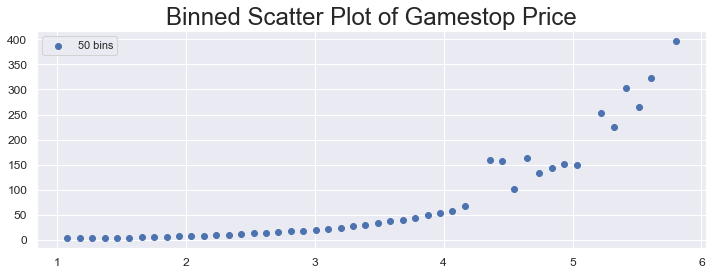

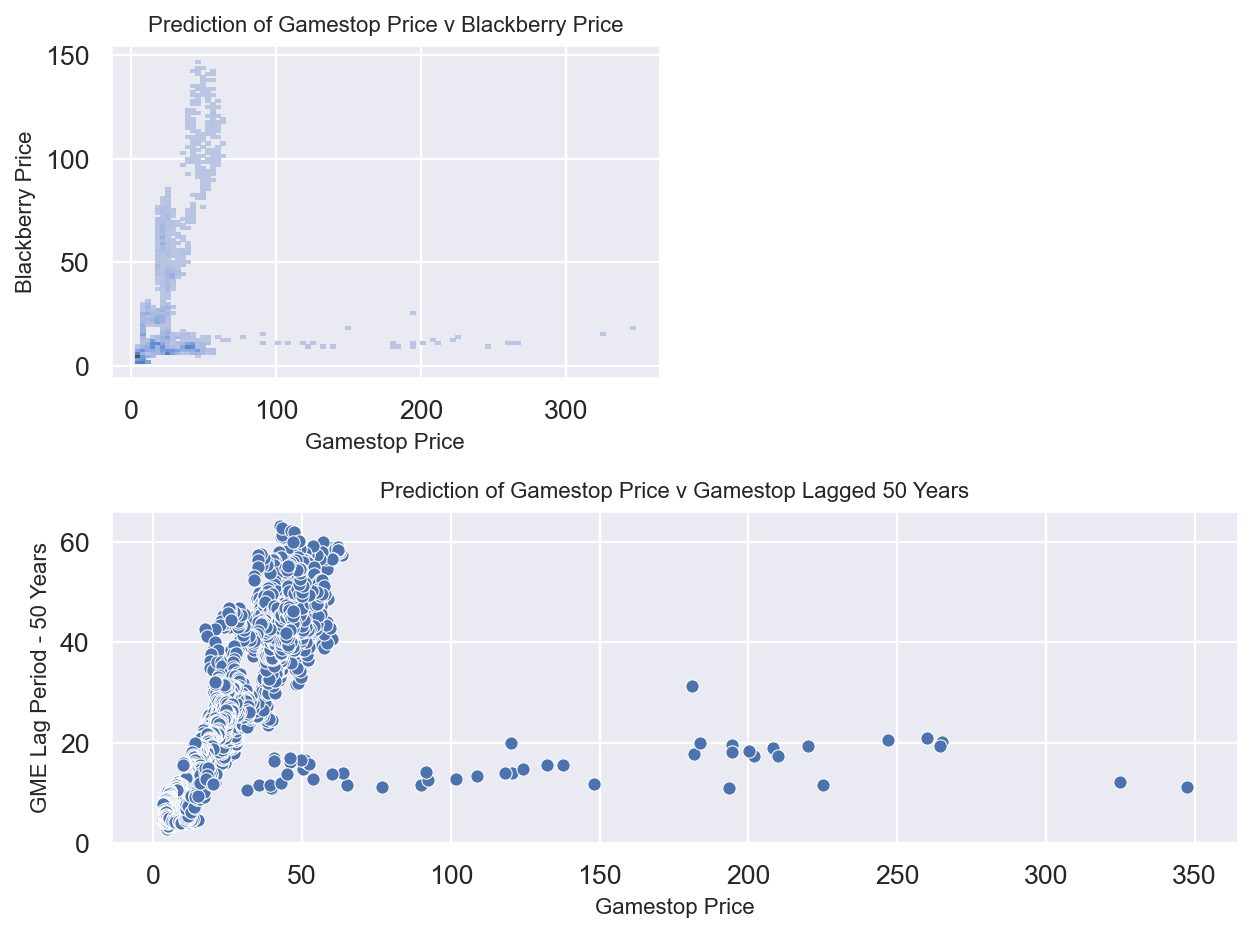

In [19]:
# sns.pairplot(data = gme, kind = 'hist',
                  # plot_kws = {'bins': 100}, diag_kws = {'bins': 10})
# plt.show()


# Binned scatter plot (you should know this as an economist)
from scipy.stats import binned_statistic

# binned_statistic?
n = 50
bin_mean, bin_edge, bin_number = binned_statistic(np.log(gme.Close), gme.High, bins = n)

x = np.average([bin_edge[:-1], bin_edge[1:]], axis = 0)

plt.scatter(x, bin_mean, label = '%d bins' % n)
plt.title('Binned Scatter Plot of Gamestop Price')
plt.legend()




plt.figure(figsize = (8, 6), dpi = 160)
plt.subplot(2, 2, 1)
plt.title('Prediction of Gamestop Price v Blackberry Price', fontsize=10)
plt.xlabel('Gamestop Price', fontsize=10)
plt.ylabel('Blackberry Price', fontsize=10)
sns.histplot(x = 'Close', y = 'bb_close', data = gme, bins = 100)


plt.subplot(2, 1, 2)
sns.scatterplot(data = gme, x = 'Close', y = 'gme_lag_period2')
plt.xlabel('Gamestop Price', fontsize=10)
plt.ylabel('GME Lag Period - 50 Years', fontsize=10)
plt.title('Prediction of Gamestop Price v Gamestop Lagged 50 Years', fontsize=10)


plt.tight_layout()
plt.savefig('figure')